# Model Train for Sentiment Analysis Honkai: Star Rail Reviews Apps

## Import Library

In [1]:
!pip install Sastrawi
!pip install tensorflow
!pip install gensim==4.3.2
!pip install scipy==1.11.4

In [30]:
# ====== Built-in & Utility Libraries ======
import re
import csv
import string
import datetime as dt
from io import StringIO

# ====== Data Handling & Visualization ======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ====== Web & Request ======
import requests

# ====== NLP (Text Preprocessing) ======
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# ====== Machine Learning ======
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# ====== Deep Learning (TensorFlow / Keras) ======
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Download resources
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Load Data

In [4]:
# Link CSV
url = 'https://raw.githubusercontent.com/jasmeinalbr/Submission_Sentiment_Analysis/main/honkai_star_rail_reviews.csv'

# Load dataset
app_reviews_df = pd.read_csv(url)

In [5]:
# Tampilkan 5 baris pertama
print("5 Baris pertama dataset:")
app_reviews_df.head()

5 Baris pertama dataset:


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,32063696-a983-49ac-8378-8b99cda18013,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"cut scene, character, bangunan, grafik,alur ce...",5,15,3.2.0,2025-04-09 11:21:03,NaN,NaN,3.2.0
1,e688ee7d-44e6-40df-aec9-3ecc55aff8c6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"semakin lama semakin tidak ramah f2p, sistem g...",1,24,3.2.0,2025-04-09 14:32:07,NaN,NaN,3.2.0
2,ded3faf6-e8c6-4a59-b7c6-1870eeeec2ed,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aku bisa bilang overall story itu awesome. mer...,5,8,3.2.0,2025-04-09 03:39:24,NaN,NaN,3.2.0
3,ebaa30c5-ddc7-448b-b4e3-34dacecaf748,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Visual oke, gameplay mudah dipahami, story lum...",4,1,3.2.0,2025-04-09 03:20:15,NaN,NaN,3.2.0
4,356a6832-bf17-44f0-9d74-3c28bb3a69f1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"jujur ini game bagus banget, mulai dari story,...",5,0,3.2.0,2025-04-09 01:49:55,NaN,NaN,3.2.0


In [6]:
# Cek jumlah baris dan kolom data
print("\nJumlah data:", app_reviews_df.shape)


Jumlah data: (25215, 11)


In [7]:
# Cek informasi data
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25215 entries, 0 to 25214
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              25215 non-null  object
 1   userName              25215 non-null  object
 2   userImage             25215 non-null  object
 3   content               25215 non-null  object
 4   score                 25215 non-null  int64 
 5   thumbsUpCount         25215 non-null  int64 
 6   reviewCreatedVersion  17095 non-null  object
 7   at                    25215 non-null  object
 8   replyContent          805 non-null    object
 9   repliedAt             805 non-null    object
 10  appVersion            17095 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.1+ MB


In [8]:
print("Jumlah data kosong per kolom:")
print(app_reviews_df.isnull().sum())

Jumlah data kosong per kolom:
reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion     8120
at                          0
replyContent            24410
repliedAt               24410
appVersion               8120
dtype: int64


In [9]:
print("Jumlah data duplikat:")
print(app_reviews_df.duplicated().sum())

Jumlah data duplikat:
0


## Preprocessing Text

In [10]:
# Cleaning Text: Hapus mention, hashtag, link, angka, tanda baca, newline
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # remove mentions
    text = re.sub(r'#\w+', '', text)            # remove hashtags
    text = re.sub(r'RT[\s]+', '', text)         # remove RT
    text = re.sub(r'https?://\S+', '', text)    # remove links
    text = re.sub(r'\n', ' ', text)             # newline ke spasi
    text = re.sub(r'[0-9]+', '', text)          # remove angka
    text = re.sub(r'[^\w\s]', '', text)         # remove karakter selain huruf dan angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.strip()
    return text

# Case Folding: Mengubah semua karakter dalam teks menjadi huruf kecil
def casefoldingText(text):
    text = text.lower()
    return text

# Tokenizing: Memecah atau membagi string, teks menjadi daftar token
def tokenizingText(text):
    text = word_tokenize(text)
    return text

# Filtering: Menghapus stopwords dalam teks
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy","dong","deh","kayak","gk","bgt","gitu","gw","yg","dah","aja","kalo","ngga","pls","trus","tuh","lu","doang","udah","gua","banget"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# Stemming: Mengurangi kata ke bentuk dasar (hilangkan imbuhan awal dan akhir)
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

# Mengubah daftar kata menjadi kalimat
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

# Menghapus slang words dan kata-kata informal
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

### Menerapkan fungsi preprocessing

In [11]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
app_reviews_df['text_clean'] = app_reviews_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
app_reviews_df['text_casefoldingText'] = app_reviews_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
app_reviews_df['text_slangwords'] = app_reviews_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
app_reviews_df['text_tokenizingText'] = app_reviews_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
app_reviews_df['text_stopword'] = app_reviews_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
app_reviews_df['text_akhir'] = app_reviews_df['text_stopword'].apply(toSentence)

In [12]:
# Cek dataset setelah di preprocessing
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,32063696-a983-49ac-8378-8b99cda18013,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"cut scene, character, bangunan, grafik,alur ce...",5,15,3.2.0,2025-04-09 11:21:03,NaN,NaN,3.2.0,cut scene character bangunan grafikalur cerita...,cut scene character bangunan grafikalur cerita...,cut scene character bangunan grafikalur cerita...,"[cut, scene, character, bangunan, grafikalur, ...","[cut, scene, character, bangunan, grafikalur, ...",cut scene character bangunan grafikalur cerita...
1,e688ee7d-44e6-40df-aec9-3ecc55aff8c6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"semakin lama semakin tidak ramah f2p, sistem g...",1,24,3.2.0,2025-04-09 14:32:07,NaN,NaN,3.2.0,semakin lama semakin tidak ramah fp sistem gam...,semakin lama semakin tidak ramah fp sistem gam...,semakin lama semakin tidak ramah fp sistem gam...,"[semakin, lama, semakin, tidak, ramah, fp, sis...","[ramah, fp, sistem, game, pw, pergantian, meta...",ramah fp sistem game pw pergantian meta cepat ...
2,ded3faf6-e8c6-4a59-b7c6-1870eeeec2ed,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aku bisa bilang overall story itu awesome. mer...,5,8,3.2.0,2025-04-09 03:39:24,NaN,NaN,3.2.0,aku bisa bilang overall story itu awesome mere...,aku bisa bilang overall story itu awesome mere...,aku bisa bilang overall story itu awesome mere...,"[aku, bisa, bilang, overall, story, itu, aweso...","[bilang, overall, story, awesome, bawa, tema, ...",bilang overall story awesome bawa tema kek gim...
3,ebaa30c5-ddc7-448b-b4e3-34dacecaf748,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Visual oke, gameplay mudah dipahami, story lum...",4,1,3.2.0,2025-04-09 03:20:15,NaN,NaN,3.2.0,Visual oke gameplay mudah dipahami story lumay...,visual oke gameplay mudah dipahami story lumay...,visual oke gameplay mudah dipahami story lumay...,"[visual, oke, gameplay, mudah, dipahami, story...","[visual, oke, gameplay, mudah, dipahami, story...",visual oke gameplay mudah dipahami story lumay...
4,356a6832-bf17-44f0-9d74-3c28bb3a69f1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"jujur ini game bagus banget, mulai dari story,...",5,0,3.2.0,2025-04-09 01:49:55,NaN,NaN,3.2.0,jujur ini game bagus banget mulai dari story d...,jujur ini game bagus banget mulai dari story d...,jujur ini game bagus banget mulai dari story d...,"[jujur, ini, game, bagus, banget, mulai, dari,...","[jujur, game, bagus, story, design, karakter, ...",jujur game bagus story design karakter animasi...


## Labeling Data

In [13]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [14]:
# Fungsi untuk menentukan polaritas sentimen
def sentiment_analysis_lexicon_indonesia(text):

    score = 0 # Inisialisasi skor sentimen ke 0
    unmatched = []

    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]
        else:
            unmatched.append(word)

    polarity='' # Inisialisasi variabel polaritas

    if (score > 1):
        polarity = 'positive'
    elif (score < -1):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity, unmatched

In [15]:
# Menerapkan fungsi ke kolom token hasil preprocessing
results = app_reviews_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)

# Pecah hasil tuple jadi dua kolom: skor dan label
results = list(zip(*results))
app_reviews_df['polarity_score'] = results[0]
app_reviews_df['polarity'] = results[1]
app_reviews_df['unmatched_words'] = results[2]

# Lihat distribusi label
print(app_reviews_df['polarity'].value_counts())

polarity
positive    15157
neutral      6503
negative     3555
Name: count, dtype: int64


In [16]:
print(app_reviews_df['unmatched_words'].head(10))

0    [cut, scene, character, bangunan, grafikalur, ...
1    [fp, pw, pergantian, meta, ber, investasi, tim...
2    [bilang, overall, story, awesome, tema, kek, g...
3    [visual, gameplay, dipahami, story, dibilang, ...
4    [story, design, karakter, animasi, genshin, im...
5    [update, kali, karakternya, castorice, animasi...
6    [versi, honkai, star, rail, rpg, storynya, kar...
7    [alasan, menyarankan, orang, memainkan, develo...
8    [style, battlenya, turn, based, build, karakte...
9    [story, ps, game², ps, tdk, voice, pack, dialo...
Name: unmatched_words, dtype: object


In [17]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity,unmatched_words
0,32063696-a983-49ac-8378-8b99cda18013,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"cut scene, character, bangunan, grafik,alur ce...",5,15,3.2.0,2025-04-09 11:21:03,NaN,NaN,3.2.0,cut scene character bangunan grafikalur cerita...,cut scene character bangunan grafikalur cerita...,cut scene character bangunan grafikalur cerita...,"[cut, scene, character, bangunan, grafikalur, ...","[cut, scene, character, bangunan, grafikalur, ...",cut scene character bangunan grafikalur cerita...,18,positive,"[cut, scene, character, bangunan, grafikalur, ..."
1,e688ee7d-44e6-40df-aec9-3ecc55aff8c6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"semakin lama semakin tidak ramah f2p, sistem g...",1,24,3.2.0,2025-04-09 14:32:07,NaN,NaN,3.2.0,semakin lama semakin tidak ramah fp sistem gam...,semakin lama semakin tidak ramah fp sistem gam...,semakin lama semakin tidak ramah fp sistem gam...,"[semakin, lama, semakin, tidak, ramah, fp, sis...","[ramah, fp, sistem, game, pw, pergantian, meta...",ramah fp sistem game pw pergantian meta cepat ...,20,positive,"[fp, pw, pergantian, meta, ber, investasi, tim..."
2,ded3faf6-e8c6-4a59-b7c6-1870eeeec2ed,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aku bisa bilang overall story itu awesome. mer...,5,8,3.2.0,2025-04-09 03:39:24,NaN,NaN,3.2.0,aku bisa bilang overall story itu awesome mere...,aku bisa bilang overall story itu awesome mere...,aku bisa bilang overall story itu awesome mere...,"[aku, bisa, bilang, overall, story, itu, aweso...","[bilang, overall, story, awesome, bawa, tema, ...",bilang overall story awesome bawa tema kek gim...,14,positive,"[bilang, overall, story, awesome, tema, kek, g..."
3,ebaa30c5-ddc7-448b-b4e3-34dacecaf748,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Visual oke, gameplay mudah dipahami, story lum...",4,1,3.2.0,2025-04-09 03:20:15,NaN,NaN,3.2.0,Visual oke gameplay mudah dipahami story lumay...,visual oke gameplay mudah dipahami story lumay...,visual oke gameplay mudah dipahami story lumay...,"[visual, oke, gameplay, mudah, dipahami, story...","[visual, oke, gameplay, mudah, dipahami, story...",visual oke gameplay mudah dipahami story lumay...,10,positive,"[visual, gameplay, dipahami, story, dibilang, ..."
4,356a6832-bf17-44f0-9d74-3c28bb3a69f1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"jujur ini game bagus banget, mulai dari story,...",5,0,3.2.0,2025-04-09 01:49:55,NaN,NaN,3.2.0,jujur ini game bagus banget mulai dari story d...,jujur ini game bagus banget mulai dari story d...,jujur ini game bagus banget mulai dari story d...,"[jujur, ini, game, bagus, banget, mulai, dari,...","[jujur, game, bagus, story, design, karakter, ...",jujur game bagus story design karakter animasi...,19,positive,"[story, design, karakter, animasi, genshin, im..."


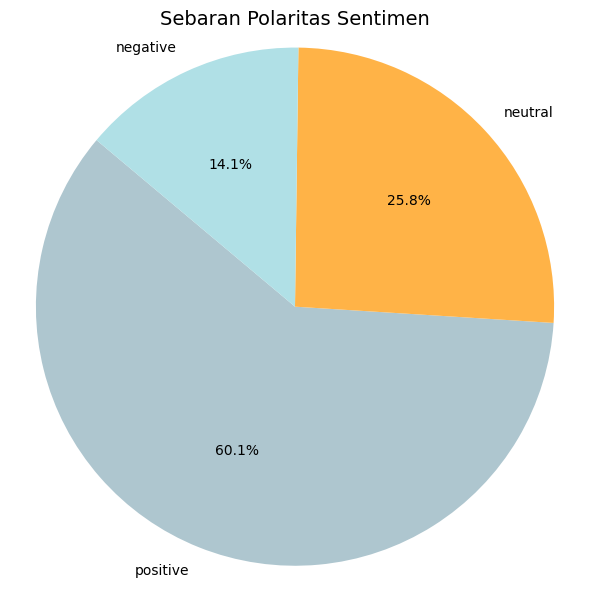

In [18]:
# Visualisasi sebaran polaritas dengan pie chart
sentiment_counts = app_reviews_df['polarity'].value_counts()

# Label dan jumlah
labels = sentiment_counts.index
sizes = sentiment_counts.values

# Warna pie chart
colors = ['#AEC6CF', '#FFB347', '#B0E0E6']

# Buat pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Sebaran Polaritas Sentimen', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Eksplorasi Label

In [19]:
# Fungsi untuk membuat wordcloud dari list token
def generate_wordcloud(text_tokens, title, colormap='Set2'):
    # Gabungkan semua token jadi 1 string panjang
    all_text = ' '.join([' '.join(tokens) for tokens in text_tokens])

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormap,
        max_words=200
    ).generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

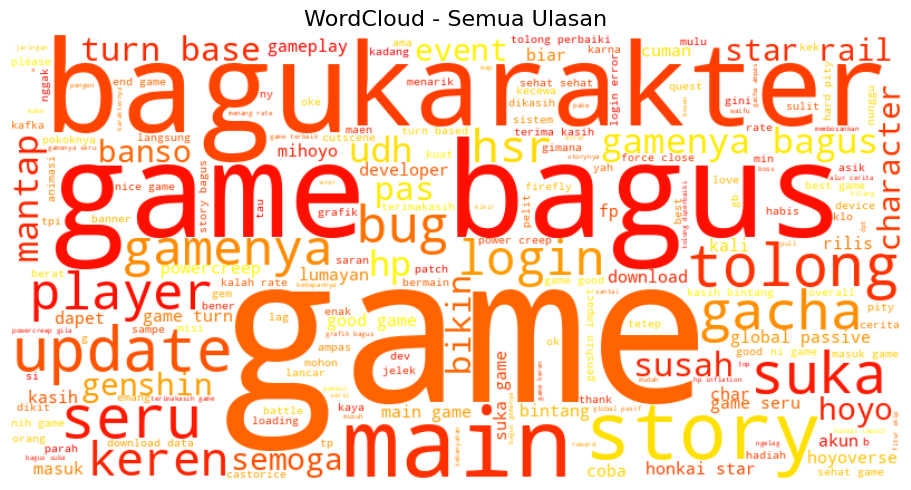

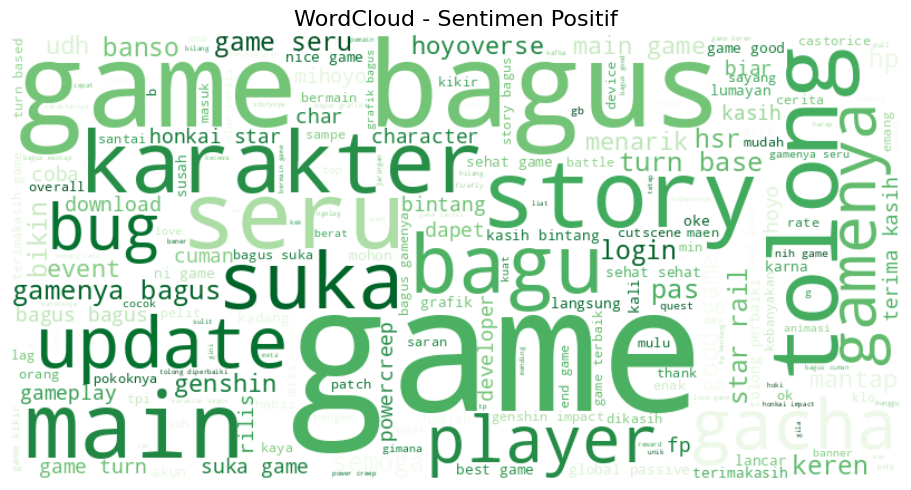

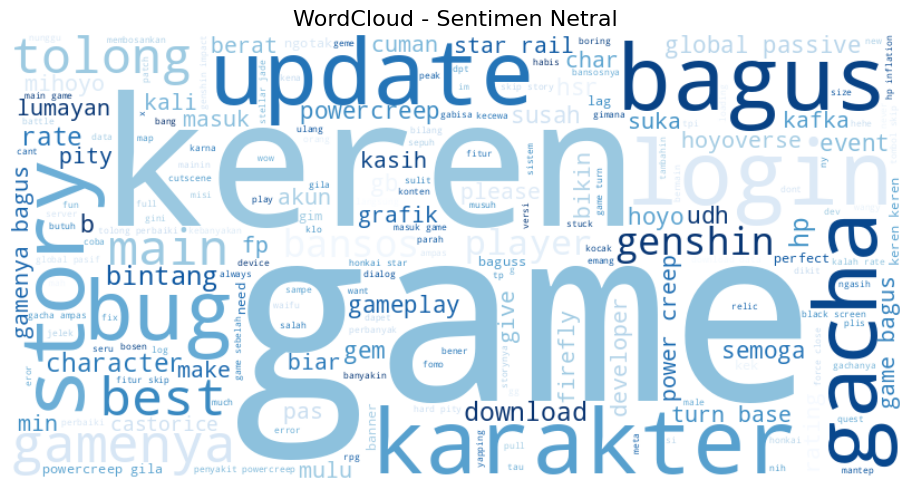

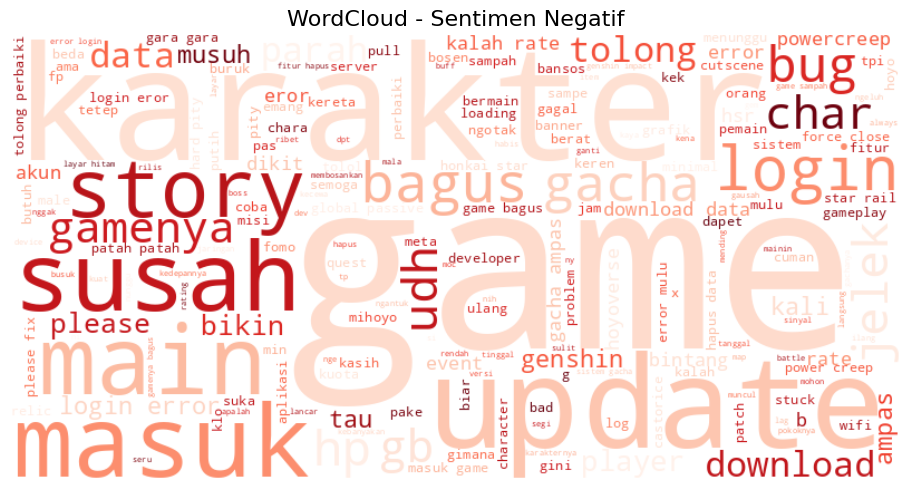

In [20]:
# WordCloud: Semua data (gabungan)
generate_wordcloud(
    app_reviews_df['text_stopword'],
    title='WordCloud - Semua Ulasan',
    colormap='autumn'
)

# WordCloud: Sentimen Positif
generate_wordcloud(
    app_reviews_df[app_reviews_df['polarity'] == 'positive']['text_stopword'],
    title='WordCloud - Sentimen Positif',
    colormap='Greens'
)

# WordCloud: Sentimen Netral
generate_wordcloud(
    app_reviews_df[app_reviews_df['polarity'] == 'neutral']['text_stopword'],
    title='WordCloud - Sentimen Netral',
    colormap='Blues'
)

# WordCloud: Sentimen Negatif
generate_wordcloud(
    app_reviews_df[app_reviews_df['polarity'] == 'negative']['text_stopword'],
    title='WordCloud - Sentimen Negatif',
    colormap='Reds'
)

## Skema 1
- Pelatihan: CNN dan LSTM
- Ekstraksi Fitur: Tokenisasi + Padding
- Pembagian Data: 70/30

### Data Splitting dan Ekstraksi Fitur

In [21]:
# Pisahkan data menjadi fitur dan label (sentimen)
X = app_reviews_df['text_akhir'].astype(str)
y = app_reviews_df['polarity']

# 2. Encode label (positif, negatif, netral → 0, 1, 2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# 3. Tokenisasi dan padding
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

maxlen = 100  # panjang input sequence
X_padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

# Split data 70:30
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.3, random_state=42)

### Modeling

In [22]:
# Menerapkan Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

vocab_size = len(tokenizer.word_index) + 1

In [23]:
# Model CNN
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=maxlen))
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 kelas: pos, netral, neg

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history_cnn = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
loss, acc = model.evaluate(X_test, y_test)
print(f"Akurasi Test: {acc:.4f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


276/276 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.6616 - loss: 0.7907 - val_accuracy: 0.8697 - val_loss: 0.3462
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.8892 - loss: 0.2913 - val_accuracy: 0.8879 - val_loss: 0.2923
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.9352 - loss: 0.1623 - val_accuracy: 0.8866 - val_loss: 0.3029
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9525 - loss: 0.1205 - val_accuracy: 0.8920 - val_loss: 0.3243
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.9625 - loss: 0.0979 - val_accuracy: 0.8814 - val_loss: 0.3746
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8826 - loss: 0.3056
Akurasi Test: 0.8879


In [24]:
# Inference Model CNN
y_pred = model.predict(X_test)

# Ambil kelas prediksi (argmax dari one-hot)
y_pred_classes = np.argmax(y_pred, axis=1)

# Kembalikan ke label aslinya
predicted_labels = label_encoder.inverse_transform(y_pred_classes)

# Contoh lihat hasil prediksi
for i in range(3):
    print(f"Teks: {X.iloc[i]}")
    print(f"Label Asli: {label_encoder.inverse_transform([np.argmax(y_test[i])])[0]}")
    print(f"Prediksi Model: {predicted_labels[i]}")
    print("---")

237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Teks: cut scene character bangunan grafikalur cerita overall bagus disayangkan power creep patch hp inflasi musuh content end game memaksa pemain membeli itemgacha character terbaru game bermain santai kompetisi game direkomendasikan yapping game dibersihkan fokus cerita utama sekian ty
Label Asli: positive
Prediksi Model: positive
---
Teks: ramah fp sistem game pw pergantian meta cepat ber investasi timkarakter berguna pergantian meta cepat tim berguna kualitas story telling semenjak menurun drastis yapping black screen
Label Asli: neutral
Prediksi Model: neutral
---
Teks: bilang overall story awesome bawa tema kek gimana spoiler alert belobog biasacool xianzhou comment penacony best story ever amphoreus selesai cutscenes beuh btw global passive op emang ngidupin character itungan op pas main mov itungan tetep mati kesempatan hidup
Label Asli: positive
Prediksi Model: positive
---


In [25]:
# Model LSTM
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history_lstm = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
loss, acc = model.evaluate(X_test, y_test)
print(f"Akurasi Test: {acc:.4f}")

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 50s 161ms/step - accuracy: 0.5860 - loss: 0.9563 - val_accuracy: 0.6046 - val_loss: 0.9302
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 87s 178ms/step - accuracy: 0.5930 - loss: 0.9495 - val_accuracy: 0.6046 - val_loss: 0.9300
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 77s 159ms/step - accuracy: 0.6052 - loss: 0.9300 - val_accuracy: 0.6046 - val_loss: 0.9293
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - accuracy: 0.6021 - loss: 0.9359 - val_accuracy: 0.6046 - val_loss: 0.9302
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.5987 - loss: 0.9368 - val_accuracy: 0.6046 - val_loss: 0.9294
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.5957 - loss: 0.9422 - val_accuracy: 0.6046 - val_loss: 0.9292
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 49s 178ms/step - accuracy: 0.5976 - loss: 0.9374 - val_accuracy: 0.6046 - val_loss: 0.9289
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 44s 159ms/step - accuracy: 0.5988 - loss: 0

In [26]:
# Inference Model LSTM
y_pred = model.predict(X_test)

# Ambil kelas prediksi (argmax dari one-hot)
y_pred_classes = np.argmax(y_pred, axis=1)

# Kembalikan ke label aslinya
predicted_labels = label_encoder.inverse_transform(y_pred_classes)

# Contoh lihat hasil prediksi
for i in range(3):
    print(f"Teks: {X.iloc[i]}")
    print(f"Label Asli: {label_encoder.inverse_transform([np.argmax(y_test[i])])[0]}")
    print(f"Prediksi Model: {predicted_labels[i]}")
    print("---")

237/237 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
Teks: cut scene character bangunan grafikalur cerita overall bagus disayangkan power creep patch hp inflasi musuh content end game memaksa pemain membeli itemgacha character terbaru game bermain santai kompetisi game direkomendasikan yapping game dibersihkan fokus cerita utama sekian ty
Label Asli: positive
Prediksi Model: positive
---
Teks: ramah fp sistem game pw pergantian meta cepat ber investasi timkarakter berguna pergantian meta cepat tim berguna kualitas story telling semenjak menurun drastis yapping black screen
Label Asli: neutral
Prediksi Model: positive
---
Teks: bilang overall story awesome bawa tema kek gimana spoiler alert belobog biasacool xianzhou comment penacony best story ever amphoreus selesai cutscenes beuh btw global passive op emang ngidupin character itungan op pas main mov itungan tetep mati kesempatan hidup
Label Asli: positive
Prediksi Model: positive
---


In [27]:
# Visualisasi plot
def plot_metrics(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{model_name} - Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

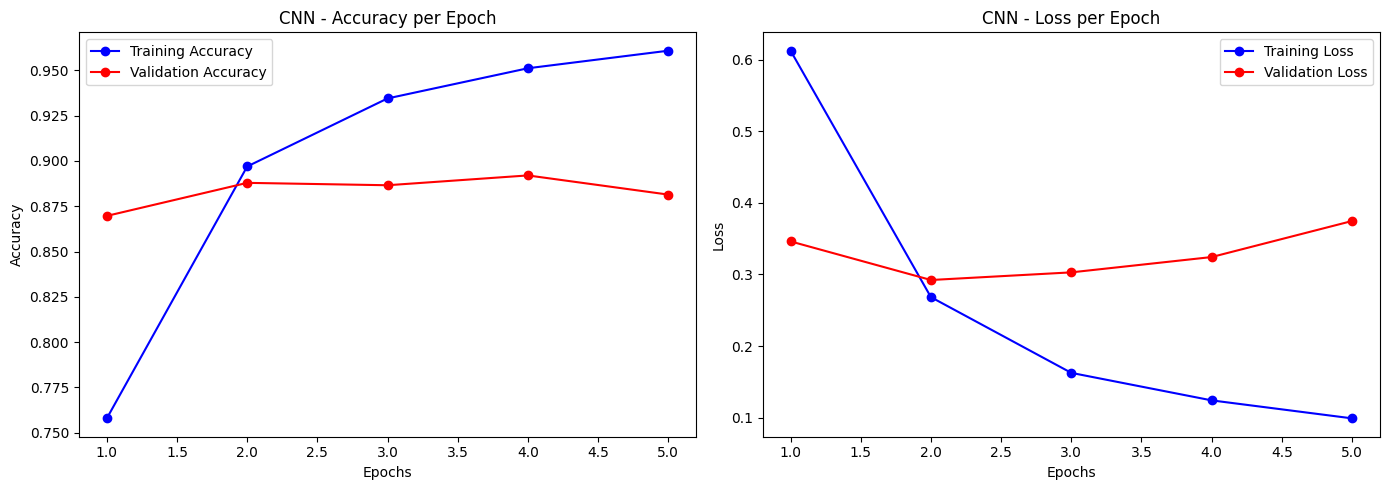

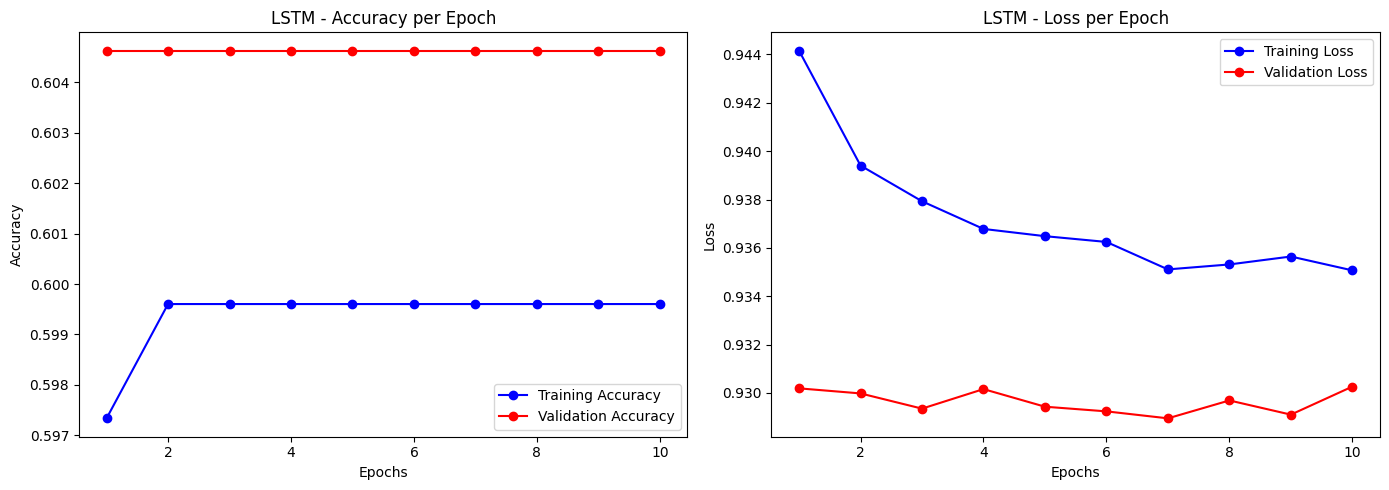

In [28]:
# history CNN
plot_metrics(history_cnn, model_name="CNN")

# history LSTM
plot_metrics(history_lstm, model_name="LSTM")

## Skema 2:

Pelatihan: LR dan SVM

Ekstraksi Fitur: Word2Vec

Pembagian Data: 80/20

### Data Splitting dan Ekstraksi Fitur

In [37]:
# Pisahkan data
X_text = app_reviews_df['text_akhir'].astype(str)
y = app_reviews_df['polarity']

# Tokenisasi
tokenized_sentences = [sentence.split() for sentence in X_text]

# Train Word2Vec
w2v_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    epochs=30
)

# Fungsi ekstrak rata-rata vektor Word2Vec
def get_avg_vector(tokens, model, vector_size=300):
    valid_tokens = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(valid_tokens, axis=0) if valid_tokens else np.zeros(vector_size)

# Ekstrak vektor rata-rata
X_vectors = np.array([get_avg_vector(tokens, w2v_model, vector_size=300) for tokens in tokenized_sentences])

# Split sekaligus simpan teks asli
X_train_vec, X_test_vec, y_train, y_test, X_train_text, X_test_text = train_test_split(
    X_vectors, y, X_text, test_size=0.2, random_state=42
)

# Normalisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_vec)
X_test_scaled = scaler.transform(X_test_vec)

### Modeling

In [38]:
# Model Logistic Regression
logistic_regression = LogisticRegression(max_iter=2000, class_weight='balanced')

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train_scaled, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train_scaled)
y_pred_test_lr = logistic_regression.predict(X_test_scaled)

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.769730319254412
Logistic Regression - accuracy_test: 0.7707713662502479


In [39]:
# Inference Model Logistic Regression
for i in range(3):
    print(f"Teks: {X_test_text.iloc[i]}")
    print(f"Label Asli: {y_test.iloc[i]}")
    print(f"Prediksi Model: {y_pred_test_lr[i]}")
    print("---")

Teks: mydei ganteng makasih hoyo bikin mydei mati
Label Asli: positive
Prediksi Model: positive
---
Teks: blm dpt sunday
Label Asli: neutral
Prediksi Model: neutral
---
Teks: semoga gameplay cocok seleraku semoga game bagus
Label Asli: positive
Prediksi Model: positive
---


In [40]:
# Model SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_scaled, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm_model.predict(X_train_scaled)
y_pred_test_svm = svm_model.predict(X_test_scaled)

# Evaluasi akurasi model SVM
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)

SVM - accuracy_train: 0.815437239738251
SVM - accuracy_test: 0.809042236763831


In [41]:
# Inference Model SVM
for i in range(3):
    print(f"Teks: {X_test_text.iloc[i]}")
    print(f"Label Asli: {y_test.iloc[i]}")
    print(f"Prediksi Model: {y_pred_test_svm[i]}")
    print("---")

Teks: mydei ganteng makasih hoyo bikin mydei mati
Label Asli: positive
Prediksi Model: positive
---
Teks: blm dpt sunday
Label Asli: neutral
Prediksi Model: neutral
---
Teks: semoga gameplay cocok seleraku semoga game bagus
Label Asli: positive
Prediksi Model: positive
---


## Skema 3:

Pelatihan: SVM dan RF

Ekstraksi Fitur: TF-IDF

Pembagian Data: 70/30

### Data Splitting dan Ekstraksi Fitur

In [42]:
# Pisahkan data menjadi fitur dan label (sentimen)
X = app_reviews_df['text_akhir']
y = app_reviews_df['polarity']

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.85)
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

### Modeling

In [43]:
# Model SVM
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm_model.predict(X_train)
y_pred_test_svm = svm_model.predict(X_test)

# Evaluasi akurasi model SVM
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)

SVM - accuracy_train: 0.9562606232294617
SVM - accuracy_test: 0.8741573033707866


In [46]:
# Inference Model SVM
for i in range(3):
    print(f"Teks: {X.iloc[i]}")
    print(f"Label Asli: {y_test.iloc[i]}")
    print(f"Prediksi Model: {y_pred_test_svm[i]}")
    print("---")

Teks: cut scene character bangunan grafikalur cerita overall bagus disayangkan power creep patch hp inflasi musuh content end game memaksa pemain membeli itemgacha character terbaru game bermain santai kompetisi game direkomendasikan yapping game dibersihkan fokus cerita utama sekian ty
Label Asli: positive
Prediksi Model: positive
---
Teks: ramah fp sistem game pw pergantian meta cepat ber investasi timkarakter berguna pergantian meta cepat tim berguna kualitas story telling semenjak menurun drastis yapping black screen
Label Asli: neutral
Prediksi Model: neutral
---
Teks: bilang overall story awesome bawa tema kek gimana spoiler alert belobog biasacool xianzhou comment penacony best story ever amphoreus selesai cutscenes beuh btw global passive op emang ngidupin character itungan op pas main mov itungan tetep mati kesempatan hidup
Label Asli: positive
Prediksi Model: positive
---


In [47]:
# Model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9852124645892352
Random Forest - accuracy_test: 0.8564441506939855


In [48]:
# Inference Model Random Forest
for i in range(3):
    print(f"Teks: {X.iloc[i]}")
    print(f"Label Asli: {y_test.iloc[i]}")
    print(f"Prediksi Model: {y_pred_test_rf[i]}")
    print("---")

Teks: cut scene character bangunan grafikalur cerita overall bagus disayangkan power creep patch hp inflasi musuh content end game memaksa pemain membeli itemgacha character terbaru game bermain santai kompetisi game direkomendasikan yapping game dibersihkan fokus cerita utama sekian ty
Label Asli: positive
Prediksi Model: positive
---
Teks: ramah fp sistem game pw pergantian meta cepat ber investasi timkarakter berguna pergantian meta cepat tim berguna kualitas story telling semenjak menurun drastis yapping black screen
Label Asli: neutral
Prediksi Model: neutral
---
Teks: bilang overall story awesome bawa tema kek gimana spoiler alert belobog biasacool xianzhou comment penacony best story ever amphoreus selesai cutscenes beuh btw global passive op emang ngidupin character itungan op pas main mov itungan tetep mati kesempatan hidup
Label Asli: positive
Prediksi Model: positive
---
